# USING IRIS DATA SET TO MAKE AN INTELLIGENT MODEL THAT CAN INTELLIGENTLY CLASSIFY THE SPECIES OF A FLOWER

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
import textwrap
from pathlib import Path

In [3]:
iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.rename(columns={
    "sepal length (cm)": "sepal_length",
    "sepal width (cm)": "sepal_width",
    "petal length (cm)": "petal_length",
    "petal width (cm)": "petal_width",
}, inplace=True)

X = df.drop(columns=["target"])
y = df["target"]

feature_names = list(X.columns)
target_names = list(iris.target_names)

# TRAIN TEST SPLIT

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# BUILD PIPELINE

In [5]:
pipe_dt = Pipeline([("clf", DecisionTreeClassifier(random_state=42))])
param_grid_dt = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 3, 4],
}

pipe_knn = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())])
param_grid_knn = {
    "clf__n_neighbors": [3, 5, 7],
    "clf__weights": ["uniform", "distance"],
}


# HYPER PARAMETER TUNING

In [6]:
cv = 3
grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=cv, n_jobs=1)
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=cv, n_jobs=1)

grid_dt.fit(X_train, y_train)
grid_knn.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
best_knn = grid_knn.best_estimator_

best_dt_cv = grid_dt.best_score_
best_knn_cv = grid_knn.best_score_

# Choose best model by cross-val score
if best_dt_cv >= best_knn_cv:
    best_model_name = "DecisionTree"
    best_model = best_dt
    alt_model_name = "KNN"
    alt_cv = best_knn_cv
else:
    best_model_name = "KNN"
    best_model = best_knn
    alt_model_name = "DecisionTree"
    alt_cv = best_dt_cv

# EVALUATION

In [7]:
y_pred_best = best_model.predict(X_test)
test_acc_best = accuracy_score(y_test, y_pred_best)
cm_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best, target_names=target_names)

if best_model_name == "DecisionTree":
    other = best_knn
else:
    other = best_dt

y_pred_other = other.predict(X_test)
test_acc_other = accuracy_score(y_test, y_pred_other)
cm_other = confusion_matrix(y_test, y_pred_other)
report_other = classification_report(y_test, y_pred_other, target_names=target_names)

print("=== Model Selection Summary (Lite) ===")
print(f"Best by CV: {best_model_name} (CV={max(best_dt_cv, best_knn_cv):.4f}) vs {alt_model_name} (CV={alt_cv:.4f})\n")

print(f"=== {best_model_name} — Test Performance ===")
print(f"Accuracy: {test_acc_best:.4f}")
print("Confusion Matrix:")
print(cm_best)
print("\nClassification Report:")
print(report_best)

print(f"\n=== {alt_model_name} — Test Performance ===")
print(f"Accuracy: {test_acc_other:.4f}")
print("Confusion Matrix:")
print(cm_other)
print("\nClassification Report:")
print(report_other)

=== Model Selection Summary (Lite) ===
Best by CV: DecisionTree (CV=0.9583) vs KNN (CV=0.9583)

=== DecisionTree — Test Performance ===
Accuracy: 0.9667
Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


=== KNN — Test Performance ===
Accuracy: 0.9333
Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.

# VISUALIZATIONS

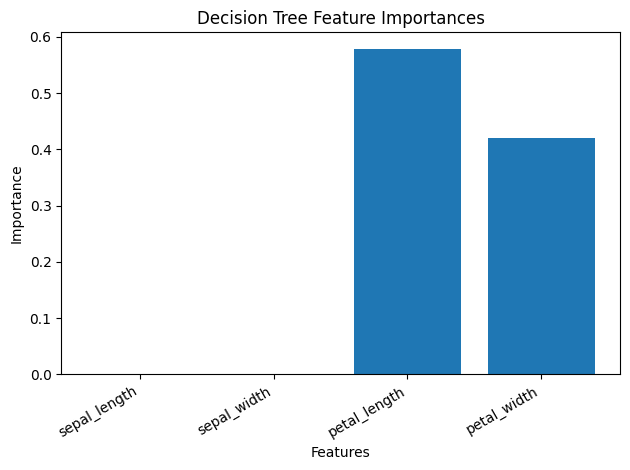

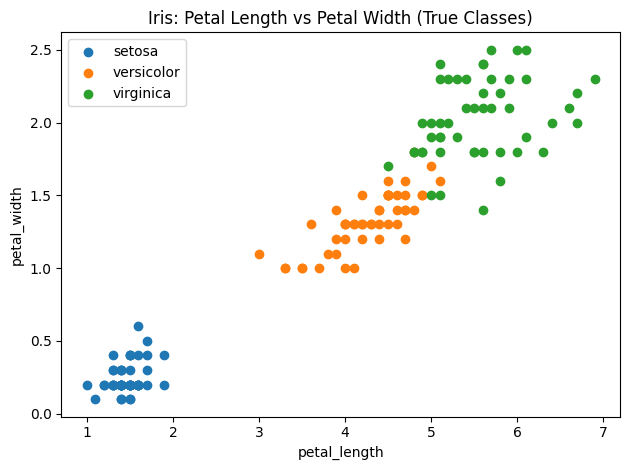

In [8]:
def plot_feature_importances(model, feature_names):
    if hasattr(model, "named_steps"):
        clf = model.named_steps.get("clf", None)
    else:
        clf = model
    if clf is None or not hasattr(clf, "feature_importances_"):
        return False

    importances = clf.feature_importances_
    fig = plt.figure()
    plt.title("Decision Tree Feature Importances")
    plt.bar(range(len(importances)), importances, tick_label=feature_names)
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
    return True

def plot_scatter(df, target_names):
    fig = plt.figure()
    for i, name in enumerate(target_names):
        subset = df[df["target"] == i]
        plt.scatter(subset["petal_length"], subset["petal_width"], label=name)
    plt.title("Iris: Petal Length vs Petal Width (True Classes)")
    plt.xlabel("petal_length")
    plt.ylabel("petal_width")
    plt.legend()
    plt.tight_layout()
    plt.show()

_ = plot_feature_importances(best_model if best_model_name=="DecisionTree" else best_dt, feature_names)
plot_scatter(df, target_names)

# AGENT USAGE

In [9]:
class IrisAgent:
    def __init__(self, model, feature_order, target_names):
        self.model = model
        self.feature_order = feature_order
        self.target_names = target_names

    def predict_species(self, measurements: dict):
        missing = [f for f in self.feature_order if f not in measurements]
        if missing:
            raise ValueError(f"Missing features: {missing}")
        x = np.array([[measurements[f] for f in self.feature_order]], dtype=float)
        pred_idx = self.model.predict(x)[0]
        try:
            proba = self.model.predict_proba(x)[0].tolist()
        except Exception:
            proba = None
        return {"pred_index": int(pred_idx), "pred_label": self.target_names[pred_idx], "probabilities": proba}

agent = IrisAgent(best_model, feature_names, target_names)

print("\n=== Agent Demo Predictions (Lite) ===")
examples = [
    {"sepal_length": 5.1, "sepal_width": 3.5, "petal_length": 1.4, "petal_width": 0.2},
    {"sepal_length": 6.0, "sepal_width": 2.9, "petal_length": 4.5, "petal_width": 1.5},
    {"sepal_length": 6.7, "sepal_width": 3.0, "petal_length": 5.8, "petal_width": 2.1},
]
for i, ex in enumerate(examples, 1):
    out = agent.predict_species(ex)
    print(f"Example {i}: {ex} -> {out['pred_label']} (index={out['pred_index']})")
    if out["probabilities"] is not None:
        print(f"  class probabilities: {np.round(out['probabilities'], 3)}")


=== Agent Demo Predictions (Lite) ===
Example 1: {'sepal_length': 5.1, 'sepal_width': 3.5, 'petal_length': 1.4, 'petal_width': 0.2} -> setosa (index=0)
  class probabilities: [1. 0. 0.]
Example 2: {'sepal_length': 6.0, 'sepal_width': 2.9, 'petal_length': 4.5, 'petal_width': 1.5} -> versicolor (index=1)
  class probabilities: [0. 1. 0.]
Example 3: {'sepal_length': 6.7, 'sepal_width': 3.0, 'petal_length': 5.8, 'petal_width': 2.1} -> virginica (index=2)
  class probabilities: [0. 0. 1.]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local